In [46]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.nn import GATConv, HeteroConv, global_mean_pool, BatchNorm
import uproot
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Configuration (unchanged)
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root' 
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 64
delta_r_threshold = 2.4
hidden_dim = 32
# ----------------------------
# Helper functions for edge creation
# ----------------------------
def create_delta_r_edges(eta, phi, delta_r_threshold):
    """
    Create edge index for nodes within one type.
    """
    edge_index = []
    num_nodes = len(eta)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            delta_eta = eta[i] - eta[j]
            delta_phi = (phi[i] - phi[j] + np.pi) % (2 * np.pi) - np.pi
            delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
            if delta_r < delta_r_threshold:
                edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

def create_bipartite_delta_r_edges(eta1, phi1, eta2, phi2, delta_r_threshold):
    """
    Create edge index for nodes between two different types.
    """
    edge_index = []
    for i in range(len(eta1)):
        for j in range(len(eta2)):
            delta_eta = eta1[i] - eta2[j]
            delta_phi = (phi1[i] - phi2[j] + np.pi) % (2 * np.pi) - np.pi
            if np.sqrt(delta_eta**2 + delta_phi**2) < delta_r_threshold:
                edge_index.append([i, j])
    if len(edge_index) == 0:
        return torch.empty((2, 0), dtype=torch.long)
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

# ----------------------------
# New data loading function for heterogeneous graphs
# ----------------------------
def load_data_hetero(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    data_list = []
    
    events = tree.arrays(all_features, library='np')
    num_events = len(events[jet_features[0]])
    
    for i in range(num_events):
        # Process jet nodes
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        # Process lepton nodes (combine electrons and muons)
        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        # Handle cases with no leptons
        if len(elec_data[0]) == 0 and len(muon_data[0]) == 0:
            x_leptons = np.zeros((0, 3))
        else:
            x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
            x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
            x_leptons = np.vstack([x_elec, x_muon])
        # Pad to 13 features as in jets
        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant', constant_values=0)
        x_leptons = normalize_features(x_leptons)
        
        # Process MET nodes
        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant', constant_values=0)
        x_met = normalize_features(x_met)
        
        # Skip events with no nodes at all
        num_jets, num_leptons, num_met = x_jets.shape[0], x_leptons.shape[0], x_met.shape[0]
        if num_jets + num_leptons + num_met == 0:
            continue
        
        # Create HeteroData object and assign node features
        data = HeteroData()
        data['jet'].x = torch.tensor(x_jets, dtype=torch.float)
        data['lepton'].x = torch.tensor(x_leptons, dtype=torch.float)
        data['met'].x = torch.tensor(x_met, dtype=torch.float)
        
        # Create intra-type edges for jets using their eta and phi
        if num_jets > 0:
            jet_eta = x_jets[:, 5]
            jet_phi = x_jets[:, 1]
            edge_index_jj = create_delta_r_edges(jet_eta, jet_phi, delta_r_threshold)
        else:
            edge_index_jj = torch.empty((2, 0), dtype=torch.long)
        data['jet', 'to', 'jet'].edge_index = edge_index_jj

        # Create intra-type edges for leptons using their eta and phi
        if num_leptons > 0:
            lepton_eta = x_leptons[:, 1]
            lepton_phi = x_leptons[:, 2]
            edge_index_ll = create_delta_r_edges(lepton_eta, lepton_phi, delta_r_threshold)
        else:
            edge_index_ll = torch.empty((2, 0), dtype=torch.long)
        data['lepton', 'to', 'lepton'].edge_index = edge_index_ll

        # Create inter-type edges between jets and leptons (bidirectional)
        if num_jets > 0 and num_leptons > 0:
            jet_lepton_edges = create_bipartite_delta_r_edges(jet_eta, jet_phi, lepton_eta, lepton_phi, delta_r_threshold)
            data['jet', 'to', 'lepton'].edge_index = jet_lepton_edges
            # Reverse direction: lepton -> jet
            data['lepton', 'to', 'jet'].edge_index = jet_lepton_edges[[1, 0]]
        else:
            empty_edges = torch.empty((2, 0), dtype=torch.long)
            data['jet', 'to', 'lepton'].edge_index = empty_edges
            data['lepton', 'to', 'jet'].edge_index = empty_edges

        # (Optional) You could also create edges involving the MET node if desired.
        # Here we leave MET as an isolated node.
        
        # Add label as a global attribute
        data['y'] = torch.tensor([label], dtype=torch.float)
        data_list.append(data)
    
    return data_list

# Load and split data for heterogeneous graphs
signal_data = load_data_hetero(signal_file, label=1)
background_data = load_data_hetero(background_file, label=0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


c:\ProgramData\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [47]:
# ----------------------------
# Define a heterogeneous GNN model using HeteroConv
# ----------------------------
from torch_geometric.nn import HeteroConv

class HeteroEventClassifier(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Define heterogeneous convolutions, batch norms, etc.
        self.conv1 = HeteroConv({
            ('jet', 'to', 'jet'): GATConv(13, hidden_dim, heads=2, concat=False, add_self_loops=True),
            ('lepton', 'to', 'lepton'): GATConv(13, hidden_dim, heads=2, concat=False, add_self_loops=True),
            ('jet', 'to', 'lepton'): GATConv(13, hidden_dim, heads=2, concat=False, add_self_loops=False),
            ('lepton', 'to', 'jet'): GATConv(13, hidden_dim, heads=2, concat=False, add_self_loops=False)
        }, aggr='sum')
        
        self.bn_dict = torch.nn.ModuleDict({
            'jet': BatchNorm(hidden_dim),
            'lepton': BatchNorm(hidden_dim),
            'met': BatchNorm(13)
        })
        
        self.conv2 = HeteroConv({
            ('jet', 'to', 'jet'): GATConv(hidden_dim, hidden_dim // 2, heads=2, concat=False, add_self_loops=True),
            ('lepton', 'to', 'lepton'): GATConv(hidden_dim, hidden_dim // 2, heads=2, concat=False, add_self_loops=True),
            ('jet', 'to', 'lepton'): GATConv(hidden_dim, hidden_dim // 2, heads=2, concat=False, add_self_loops=False),
            ('lepton', 'to', 'jet'): GATConv(hidden_dim, hidden_dim // 2, heads=2, concat=False, add_self_loops=False)
        }, aggr='sum')
        
        self.fc = torch.nn.Linear((hidden_dim // 2) * 2 + 13, 1)

    def forward(self, data):
        # data: HeteroData object with x_dict and edge_index_dict
        x_dict, edge_index_dict = data.x_dict, data.edge_index_dict

        # First heterogeneous convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        for node_type in ['jet', 'lepton']:
            if node_type in x_dict:
                x_dict[node_type] = self.bn_dict[node_type](x_dict[node_type])
                x_dict[node_type] = F.relu(x_dict[node_type])
                x_dict[node_type] = F.dropout(x_dict[node_type], p=0.4, training=self.training)

        # Second heterogeneous convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        for node_type in ['jet', 'lepton']:
            if node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
                x_dict[node_type] = F.dropout(x_dict[node_type], p=0.4, training=self.training)

        # Number of graphs in the batch, from the global label 'y'
        num_graphs = data['y'].size(0)
        pooled_outputs = []
        # For jets and leptons, expected feature dimension:
        out_dim = self.conv2.convs[('jet', 'to', 'jet')].out_channels  # assumes same for 'lepton'
        
        # Define a helper function for pooling manually:
        def manual_pool(x, batch_vec, num_graphs, feature_dim):
            pooled = torch.zeros(num_graphs, feature_dim, device=x.device)
            for i in range(num_graphs):
                mask = (batch_vec == i)
                if mask.sum() > 0:
                    pooled[i] = x[mask].mean(dim=0)
            return pooled

        # Pool jets:
        if 'jet' in x_dict and x_dict['jet'].size(0) > 0:
            if hasattr(data['jet'], 'batch'):
                batch_vec = data['jet'].batch
            else:
                batch_vec = torch.zeros(x_dict['jet'].size(0), dtype=torch.long, device=x_dict['jet'].device)
            pooled_jet = manual_pool(x_dict['jet'], batch_vec, num_graphs, out_dim)
        else:
            pooled_jet = torch.zeros(num_graphs, out_dim, device=data['y'].device)
        pooled_outputs.append(pooled_jet)

        # Pool leptons:
        if 'lepton' in x_dict and x_dict['lepton'].size(0) > 0:
            if hasattr(data['lepton'], 'batch'):
                batch_vec = data['lepton'].batch
            else:
                batch_vec = torch.zeros(x_dict['lepton'].size(0), dtype=torch.long, device=x_dict['lepton'].device)
            pooled_lepton = manual_pool(x_dict['lepton'], batch_vec, num_graphs, out_dim)
        else:
            pooled_lepton = torch.zeros(num_graphs, out_dim, device=data['y'].device)
        pooled_outputs.append(pooled_lepton)

        # Pool MET:
        met_dim = 13
        if 'met' in x_dict and x_dict['met'].size(0) > 0:
            if hasattr(data['met'], 'batch'):
                batch_vec = data['met'].batch
            else:
                batch_vec = torch.zeros(x_dict['met'].size(0), dtype=torch.long, device=x_dict['met'].device)
            pooled_met = manual_pool(x_dict['met'], batch_vec, num_graphs, met_dim)
        else:
            pooled_met = torch.zeros(num_graphs, met_dim, device=data['y'].device)
        pooled_outputs.append(pooled_met)

        # Concatenate pooled representations: shape becomes (num_graphs, out_dim + out_dim + met_dim)
        h = torch.cat(pooled_outputs, dim=-1)
        return self.fc(h).squeeze(-1)




In [ ]:

# Training Setup (similar to before)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroEventClassifier(hidden_dim).to(device)
labels = [data['y'].item() for data in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=10, verbose=True)


c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [49]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

train_losses = []
val_losses = []
val_accuracies = []
val_roc_aucs = []

# Early Stopping Parameters
patience = 30  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
stagnant_epochs = 0

# Training Function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)  # Move entire hetero batch to device
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data['y'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing Function
def test(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)  # Move entire hetero batch to device
        with torch.no_grad():
            pred = torch.sigmoid(model(data))
            loss = criterion(pred, data['y'])
            total_loss += loss.item()
            correct += ((pred > 0.5) == data['y']).sum().item()
            y_true.append(data['y'].cpu())
            y_pred.append(pred.cpu())
    
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    
    roc_auc = roc_auc_score(y_true, y_pred)
    acc = correct / len(loader.dataset)
    val_loss = total_loss / len(loader)
    
    return acc, roc_auc, val_loss, y_true, y_pred

# Run Training with Early Stopping
for epoch in range(1, 300):  # Adjust number of epochs as needed
    loss = train()
    val_acc, val_roc_auc, val_loss, y_true, y_pred = test(test_loader)
    
    train_losses.append(loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_roc_aucs.append(val_roc_auc)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stagnant_epochs = 0  # Reset counter
    else:
        stagnant_epochs += 1
    
    if stagnant_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# # Plot Validation Loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Validation Loss')
# plt.legend()
# plt.show()
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_roc_aucs[-1]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Epoch: 01, Loss: 0.5876, Val Loss: 0.6682, Val Acc: 0.7245, Val ROC-AUC: 0.8043
Epoch: 02, Loss: 0.5137, Val Loss: 0.6489, Val Acc: 0.7395, Val ROC-AUC: 0.8315


KeyboardInterrupt: 

Model saved to hetero_event_classifier.pth
Model loaded successfully


C:\Users\sande\AppData\Local\Temp\ipykernel_1816\3584810631.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


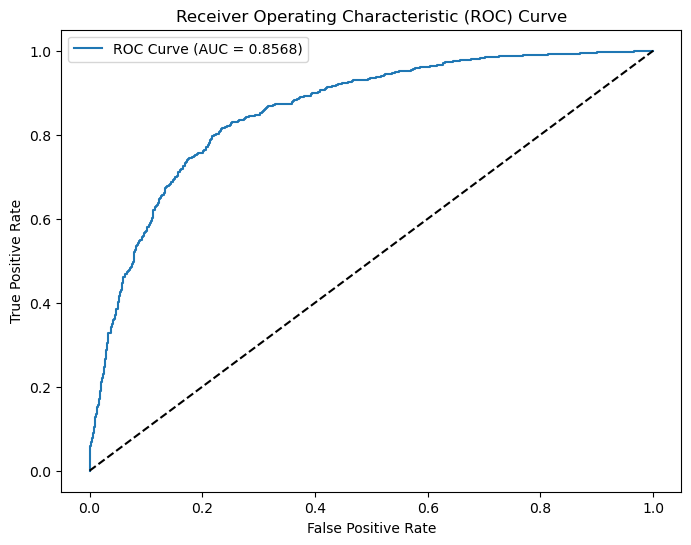

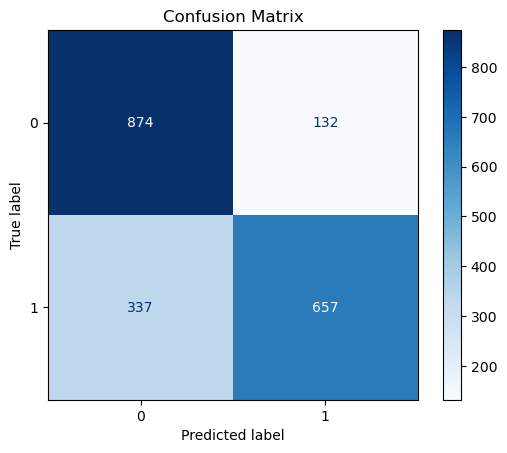

In [ ]:
# Save the model
model_save_path = "hetero_event_classifier.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Load the model
loaded_model = HeteroEventClassifier(hidden_dim).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
print("Model loaded successfully")

# Perform predictions on test data
y_true = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred = torch.sigmoid(loaded_model(data))
        y_true.append(data['y'].cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

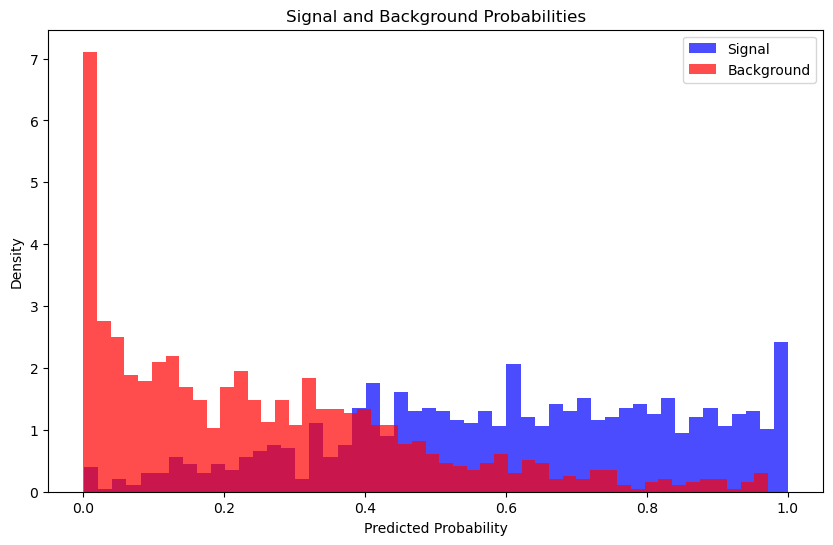

In [ ]:
# Separate signal and background probabilities
signal_probs = y_pred[y_true == 1]
background_probs = y_pred[y_true == 0]

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(signal_probs, bins=50, alpha=0.7, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.7, label='Background', color='red', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Signal and Background Probabilities')
plt.legend()
plt.show()

In [ ]:
# Calculate signal and background counts
signal_count = np.sum((y_pred_class == 1) & (y_true == 1))
background_count = np.sum((y_pred_class == 1) & (y_true == 0))

# Calculate significance
if signal_count + background_count > 0:
    significance = signal_count / np.sqrt(signal_count + background_count)
else:
    significance = 0

print(f"Signal Count: {signal_count}")
print(f"Background Count: {background_count}")
print(f"Significance: {significance}")

Signal Count: 657
Background Count: 132
Significance: 23.38981937061751


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7655
Precision: 0.8327
Recall: 0.6610
F1 Score: 0.7370
